In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

def AffineAlignOp(features, idxs, aligned_height, aligned_width, Hs):
    
    def _transform_matrix(Hs, w, h):
        _Hs = np.zeros(Hs.shape, dtype = np.float32)
        for i, H in enumerate(Hs):
            H0 = np.concatenate((H, np.array([[0, 0, 1]])), axis=0)
            A = np.array([[2.0 / w, 0, -1], [0, 2.0 / h, -1], [0, 0, 1]])
            A_inv = np.array([[w / 2.0, 0, w / 2.0], [0, h / 2.0, h/ 2.0], [0, 0, 1]])
            H0 = A.dot(H0).dot(A_inv)
            H0 = np.linalg.inv(H0)
            _Hs[i] = H0[:-1]
        return _Hs

    bz, C_feat, H_feat, W_feat = features.size()
    N = len(idxs)
    feature_select = features[idxs] # (N, feature_channel, feature_size, feature_size)
    
    Hs_new = _transform_matrix(Hs, w=W_feat, h=H_feat) # return (N, 2, 3)
    Hs_var = Variable(torch.from_numpy(Hs_new), requires_grad=False).cuda()
    flow = F.affine_grid(theta=Hs_var, size=(N, C_feat, H_feat, W_feat)).float().cuda()
    flow = flow[:,:aligned_height, :aligned_width, :]
    rois = F.grid_sample(feature_select, flow, mode='bilinear', padding_mode='border') # 'zeros' | 'border' 
    return rois
    
def CropAlignOp(feature_var, rois_var, aligned_height, aligned_width, spatial_scale):
    rois_np = rois_var.data.cpu().numpy()
    idxs = rois_np[:,0]
    affinematrixs_feat = []
    for roi in rois_np:
        x1, y1, x2, y2 = roi[1:] * float(spatial_scale)
        matrix = np.array([[aligned_width/(x2-x1), 0, -aligned_width/(x2-x1)*x1],
                           [0, aligned_height/(y2-y1), -aligned_height/(y2-y1)*y1]
                          ])
        affinematrixs_feat.append(matrix)
    affinematrixs_feat = np.array(affinematrixs_feat)
    feature_rois = AffineAlignOp(feature_var, idxs, align_size, align_size, affinematrixs_feat)
    return feature_rois


In [3]:
from nnlib.roi_align.modules.roi_align import RoIAlign

input_res = 512
feature_res = 128
align_size = 64

roialignOp = RoIAlign(aligned_height=align_size, 
                       aligned_width=align_size, 
                       spatial_scale=float(feature_res)/input_res, 
                       sampling_ratio=0)
# Usage:
#feature_rois = roialignOp(feature_var, rois_var)

# Usage:
# feature_rois = CropAlignOp(feature_var, rois_var, 
#                            aligned_height=align_size, 
#                            aligned_width=align_size, 
#                            spatial_scale=float(feature_res)/input_res)


====== Origin Image is 512*512 =======


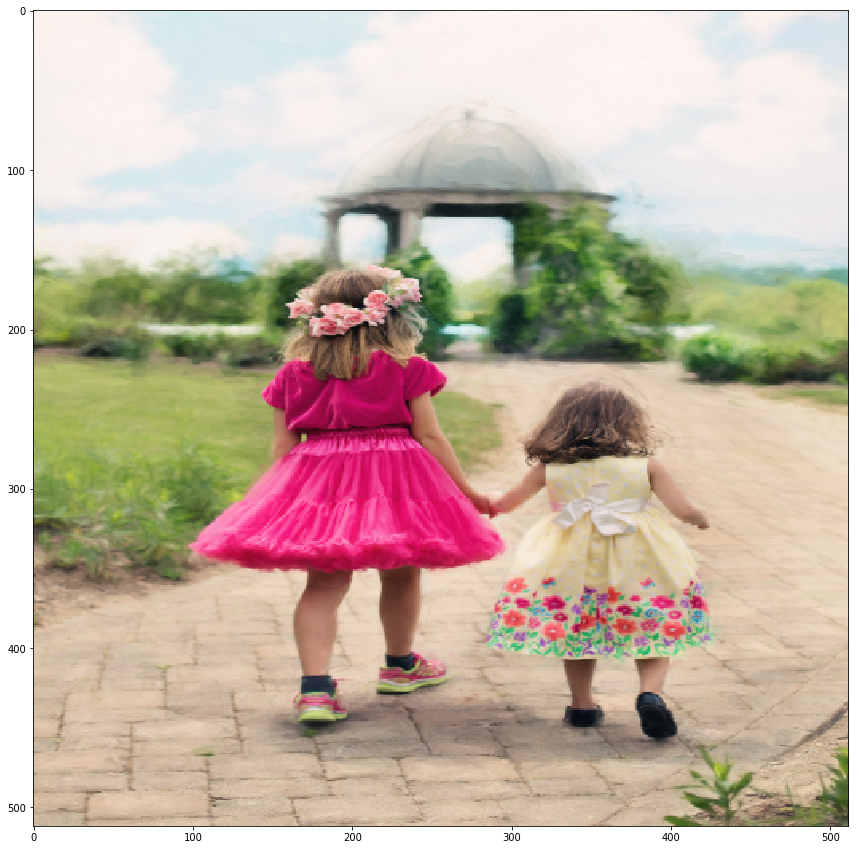

====== Opencv Crop to 300*300 =======


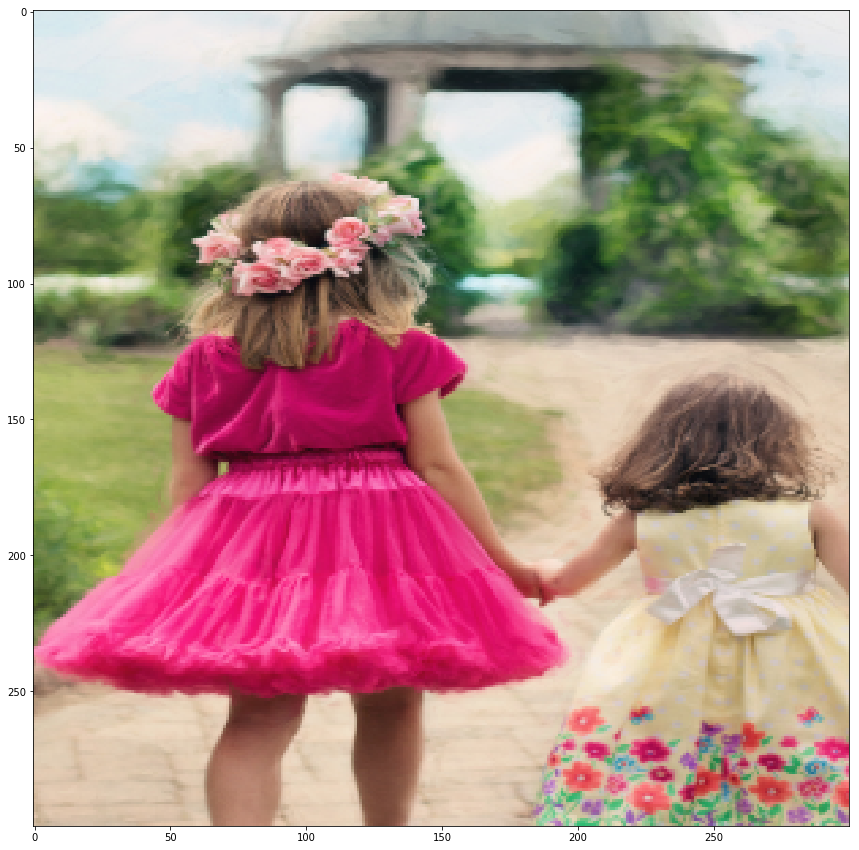

====== RoiAlign to 64*64 =======


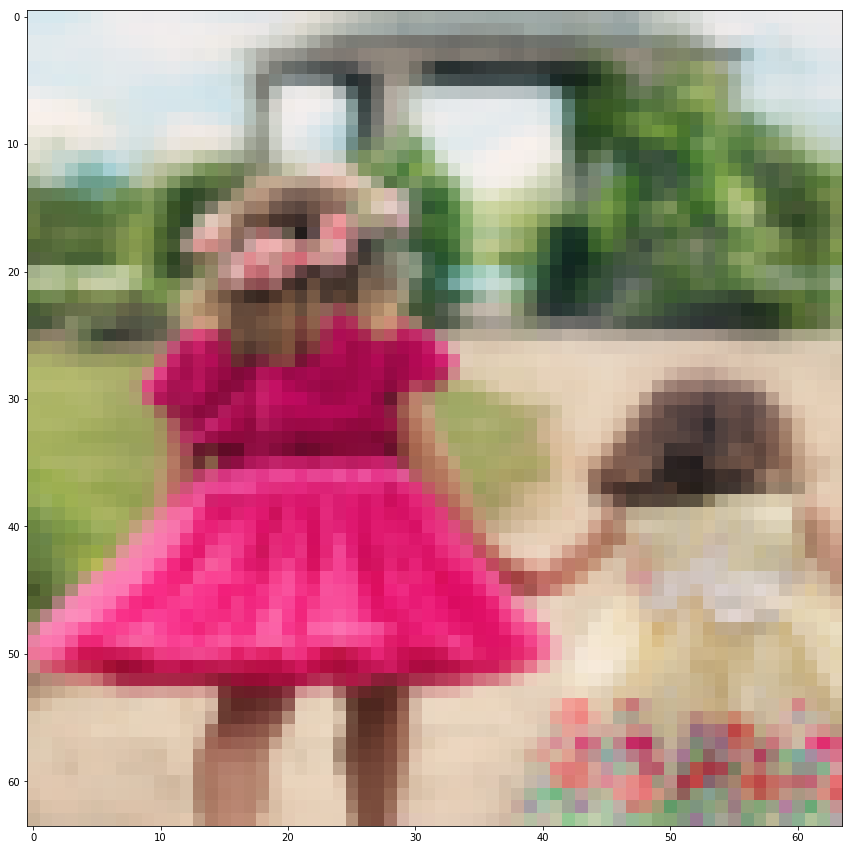

====== CropAlign to 64*64 (based on AffineAlign) =======


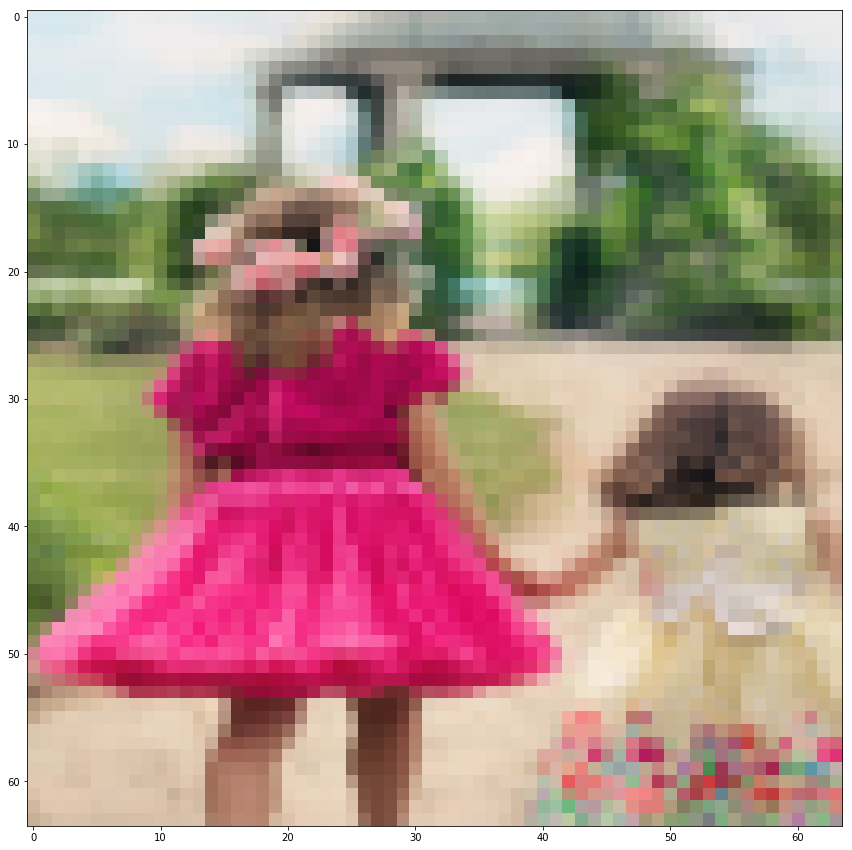

In [4]:
import cv2

import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

def myshow(img):
    plt.imshow(img)
    plt.show()
    

img = cv2.imread('/home/dalong/testimg.png')
img = cv2.resize(img, (input_res, input_res))

features = cv2.resize(img, (feature_res, feature_res))
features = np.float32(features.transpose(2, 0, 1)[np.newaxis, :, :, :])
features = Variable(torch.from_numpy(features), requires_grad=True).cuda()

bbox = [0, 100, 100, 400, 400] # [batch_ind, x1, y1, x2, y2]
rois = np.array([bbox], dtype=np.float32)
rois = Variable(torch.from_numpy(rois), requires_grad=False).cuda()

print ('====== Origin Image is %d*%d ======='%(input_res, input_res))
myshow(np.uint8(img[:,:,::-1]))

print ('====== Opencv Crop to %d*%d ======='%(bbox[3]-bbox[1], bbox[4]-bbox[2]))
myshow(np.uint8(img[bbox[2]:bbox[4],bbox[1]:bbox[3],::-1]))

print ('====== RoiAlign to %d*%d ======='%(align_size, align_size))
res = roialignOp(features, rois)
vis = res.data.cpu().numpy()[0].transpose(1,2,0)
myshow(np.uint8(vis[:,:,::-1]))

print ('====== CropAlign to %d*%d (based on AffineAlign) ======='%(align_size, align_size))
res = CropAlignOp(features, rois, 
                   aligned_height=align_size, 
                   aligned_width=align_size, 
                   spatial_scale=float(feature_res)/input_res)
vis = res.data.cpu().numpy()[0].transpose(1,2,0)
myshow(np.uint8(vis[:,:,::-1]))
